In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.loc'] = 'best'
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['font.size'] = 12
cities_label = {"London":"london", 
                "New York":"newyork", 
                "Beijing":"beijing",
                "Hong Kong":"hongkong",
                "Singapore":"singapore"}

In [2]:
def reward(P_ac, P_heat, tbuild):
    w=0.1
    P_ac = P_ac/3.6/0.43
    P_heat = P_heat/0.9/0.96
    r = -w*1*(P_ac + P_heat) - (1-w)*1*(abs(tbuild - 24 - 273.15) + abs(tbuild - 18 - 273.15))
    return r

In [3]:
def cal_reward(ax, ds_rl, timeslice=("2012", "2013")):
    ds_rl['reward'] = reward(ds_rl['URBAN_AC'].isel(landunit=1), ds_rl['URBAN_HEAT'].isel(landunit=1), ds_rl['TBUILD'].isel(landunit=1))
    return ds_rl['reward'].sel(time=slice(*timeslice)).mean().values, ds_rl['reward'].sel(time=slice(*timeslice)).std().values

In [4]:
df = pd.DataFrame(columns=["city", "mean", "std", "type"])
df_dict = {}
for city in cities_label:

    if city == "London":
        timeslice = ("2012", "2012")
    else:
        timeslice = ("2021", "2021")

    ds = xr.open_dataset('../hac_on_wasteheat/'+cities_label[city] + "/default.nc")
    ds_rl = xr.open_dataset('../clmu_sac_output/'+cities_label[city] + "_sac_clmu_sac.nc")
    ds_rl_ts = xr.open_dataset(f"../clmu_sac_output/beijing_to_{cities_label[city]}_clmu_sac.nc")
    
    mean, std = cal_reward(plt, ds, timeslice)
    df = pd.concat([df, pd.DataFrame({"city":[city], "mean":[mean], "std":[std], "type":["Default"]})])
    
    mean, std = cal_reward(plt, ds_rl, timeslice)
    df = pd.concat([df, pd.DataFrame({"city":[city], "mean":[mean], "std":[std], "type":["Local"]})])
    
    mean, std = cal_reward(plt, ds_rl_ts, timeslice)
    df = pd.concat([df, pd.DataFrame({"city":[city], "mean":[mean], "std":[std], "type":["Beijing transfer"]})])

df

,city,mean,std,type
0,London,-7.490558,1.2195758,Default
0,London,-6.5304375,1.2076737,Local
0,London,-7.3480773,1.897887,Beijing transfer
0,New York,-8.842535,2.6912062,Default
0,New York,-7.4896555,1.6290826,Local
0,New York,-7.944302,2.1567843,Beijing transfer
0,Beijing,-12.942721,4.852691,Default
0,Beijing,-7.3818865,1.7486806,Local
0,Beijing,-7.3609114,1.7036912,Beijing transfer
0,Hong Kong,-11.374891,5.3298116,Default


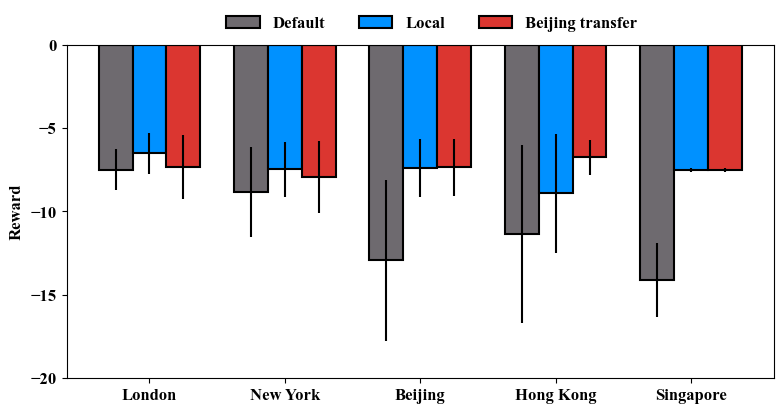

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

width = 0.25  # the width of the bars
multiplier = 0

colors = ['#6e6a6f','#0091FF','#DB3630', "#da4167",'#ff70a6']


x = np.arange(len(df['city'].unique()))

for t in df['type'].unique():
    offset = width * multiplier
    rects = plt.bar(x + offset, df[df['type']==t]['mean'], yerr=df[df['type']==t]['std'], 
                    label=t, width=width, color=colors[multiplier], edgecolor='black', linewidth=1.5)
    #ax.bar_label(rects, padding=3, fmt='%.2f', fontsize=9)
    multiplier += 1

ax.set_ylim(-20, 0)
ax.set_yticks(np.arange(-20, 1, 5))
ax.set_ylabel('Reward')
ax.set_xticks(x+width)
ax.set_xticklabels(df['city'].unique())
fig.legend(frameon=False, loc='upper center', ncol=3, bbox_to_anchor=(0.55, 1.05))
fig.tight_layout()
fig.savefig("./figs/transfer_beijing.pdf", bbox_inches='tight', dpi=300)
plt.show()